# <center> Team **LASERS** working notebook <WHOOP!!!>

## <center> _Justinn J. Jones, Hailey Schmidt, Evan Aschenbeck, Mark Zarfoss, Cameron Ho, & Garrett Moore_

***
# <center>**_Lasers, Grazers, & Fire: Using Mobile LIDAR to Estimate Prescribed Burn Forage Metrics_**
***

### <center>GeoSLAM ZEB Horizon Moblie Lidar Scanner
![](./images/scanner1.jpg) 

***
### <center> MLS before Rx fire (April)
![](./images/04.png)

***
### <center> MLS after Rx fire (May)
![](./images/05.png)

***
### 1.0 - Setup Notebook

#### Import the necessary modules 

In [1]:
import arcpy 
from arcpy.sa import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os 

#### Set workspace 

In [2]:
output = './output/'
if not os.path.exists(output):
    os.makedirs(output)

path = os.getcwd() + '\\output'
os.chdir(path)

arcpy.env.workspace = path
arcpy.env.overwriteOutput = True

figpath = '../figures/'
if not os.path.exists(figpath):
    os.makedirs(figpath)


### 2.0 - Load lidar point clouds (.las) 

Link to download the two LAS files, if necessary: 

[Click to Download](https://drive.google.com/drive/folders/1IEZjgdMmIXkhgwpQdlii5OlZr_RaYpn_)

Place in 'LAS' directory as shown below. 

In [3]:
las04 = '../LAS/04.las' # April
las05 = '../LAS/05.las' # May

#### LAS info (point count and point spacing)

In [4]:
# Set spatial reference 
sr = arcpy.SpatialReference(32614, 5703)
    # 32614: WGS 1984 UTM Zone 14N
    # 5703: NAVD88 height (m)

# Generate LAS boundary shapefile
info04 = arcpy.ddd.PointFileInformation(las04, 'info04.shp', 'LAS')
arcpy.management.DefineProjection(info04, sr)
info05 = arcpy.ddd.PointFileInformation(las05, 'info05.shp', 'LAS')
arcpy.management.DefineProjection(info05, sr)

# Export DBF as CSV
arcpy.conversion.ExportTable('info04.dbf', 'info04.csv')
arcpy.conversion.ExportTable('info05.dbf', 'info05.csv')

# Read and process CSV 
info04_ = pd.read_csv('info04.csv')
info05_ = pd.read_csv('info05.csv')
info0405 = pd.concat([info04_, info05_])
info0405.index = ['April', 'May']
ptc04 = info0405.loc['April', 'Pt_Count']
ptc05 = info0405.loc['May', 'Pt_Count']
pts04 = info0405.loc['April', 'Pt_Spacing']
pts05 = info0405.loc['May', 'Pt_Spacing']

print('Point count')
print('Apr: ' + f'{ptc04:,}')
print('May:  ' + f'{ptc05:,}')
print('Tot: ' + f'{ptc04+ptc05:,}')
print()
print('Point spacing')
print('Apr: ' + str(format(pts04*100, '.2f')) + ' cm')
print('May: ' + str(format(pts05*100, '.2f')) + ' cm')

Point count
Apr: 22,571,652
May:  9,377,597
Tot: 31,949,249

Point spacing
Apr: 1.03 cm
May: 1.59 cm


### 3.0 - Generate _digital elevation models_ (DEM) and _digital surface models_ (DSM) from LAS 

In [5]:
# set raster resolution (m)
DEM_res = 0.25
DSM_res = 0.25

arcpy.conversion.LasDatasetToRaster(las04, 'DEM04.tif', 'ELEVATION', 'BINNING MINIMUM LINEAR', 'FLOAT', 'CELLSIZE', DEM_res, 1)
arcpy.conversion.LasDatasetToRaster(las05, 'DEM05.tif', 'ELEVATION', 'BINNING MINIMUM LINEAR', 'FLOAT', 'CELLSIZE', DEM_res, 1)
arcpy.conversion.LasDatasetToRaster(las04, 'DSM04.tif', 'ELEVATION', 'BINNING MAXIMUM LINEAR', 'FLOAT', 'CELLSIZE', DSM_res, 1)
arcpy.conversion.LasDatasetToRaster(las05, 'DSM05.tif', 'ELEVATION', 'BINNING MAXIMUM LINEAR', 'FLOAT', 'CELLSIZE', DSM_res, 1)

<Result 'c:\\Users\\justi\\OneDrive - Texas A&M University\\Academics\\GEOG 676 - GIS Prog\\_group_project\\_Team_LASERS_notebook\\output\\DSM05.tif'>

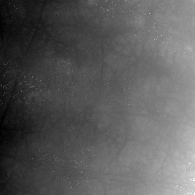

In [6]:
Render('DEM04.tif', colormap='gray')

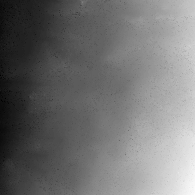

In [7]:
Render('DEM05.tif', colormap='gray')

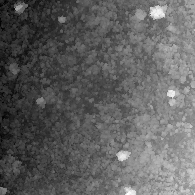

In [8]:
Render('DSM04.tif', colormap='gray')

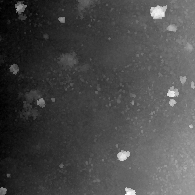

In [9]:
Render('DSM05.tif', colormap='gray')

### 4.0 - Calculate _canopy height models_ (CHM) from DEM and DSM

#### $CHM = DSM - DEM$

In [10]:
CHM04 = RasterCalculator(["DSM04.tif", "DEM04.tif"], ["x", "y"], "x-y")
CHM04.save('CHM04.tif')

CHM05 = RasterCalculator(["DSM05.tif", "DEM05.tif"], ["x", "y"], "x-y")
CHM05.save('CHM05.tif')

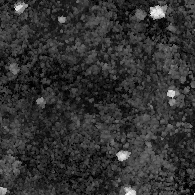

In [11]:
Render('CHM04.tif', colormap='gray')

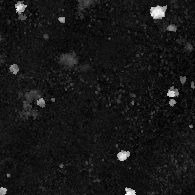

In [12]:
Render('CHM05.tif', colormap='gray')

### 5.0 - CHM Histograms

 - Convert raster to np array 
 - Stack array horizontally with hstack
 - Calculate median for each array 

In [13]:
arr04 = arcpy.RasterToNumPyArray(CHM04)
arr04hstack = np.hstack(arr04)
arr05 = arcpy.RasterToNumPyArray(CHM05)
arr05hstack = np.hstack(arr05)
arr04med = np.median(arr04hstack)
arr05med = np.median(arr05hstack)

 - Create histogram at 10 cm bins
 - Use linspace to generate bins 

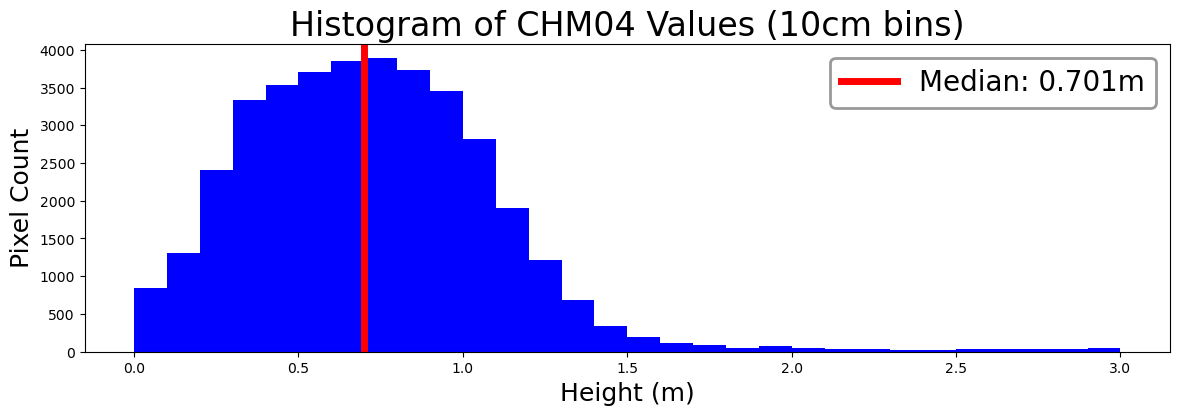

In [14]:
bins = np.linspace(0,3,31)
title = 'Histogram of CHM04 Values (10cm bins)'

plt.subplots(figsize=(14,4))
plt.axvline(arr04med, color = 'r', linewidth = 5, label = 'Median: ' + str(round(arr04med, 3)) + 'm')
plt.hist(arr04hstack, bins = bins, color = 'b')
plt.title(title, size = 24)
plt.xlabel('Height (m)', size = 18)
plt.ylabel('Pixel Count', size = 18)
leg = plt.legend(loc = 'upper right', fontsize = '20')
leg.get_frame().set_edgecolor('gray')
leg.get_frame().set_linewidth(2)
plt.savefig(figpath + title +'.png', bbox_inches='tight')
plt.show()

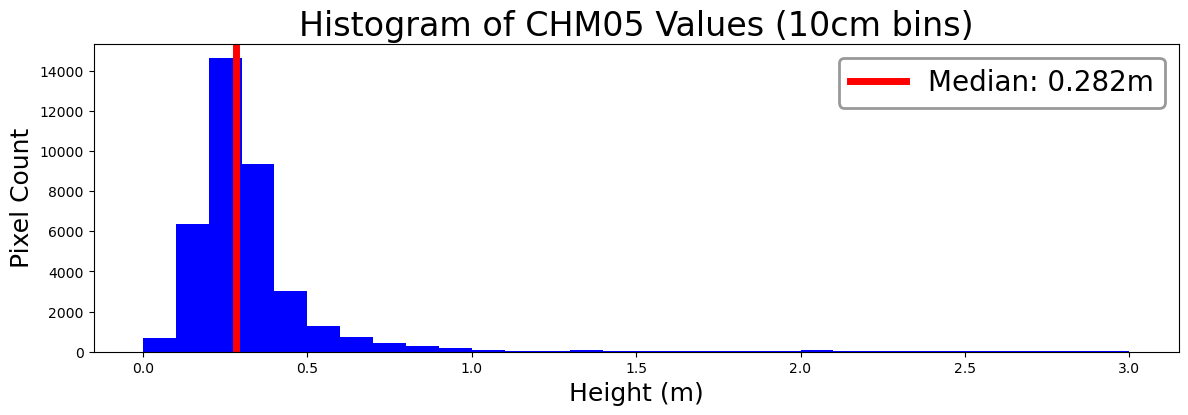

In [15]:
bins = np.linspace(0,3,31)
title = 'Histogram of CHM05 Values (10cm bins)'

plt.subplots(figsize=(14,4))
plt.axvline(arr05med, color = 'r', linewidth = 5, label = 'Median: ' + str(round(arr05med, 3)) + 'm')
plt.hist(arr05hstack, bins = bins, color = 'b')
plt.title(title, size = 24)
plt.xlabel('Height (m)', size = 18)
plt.ylabel('Pixel Count', size = 18)
leg = plt.legend(loc = 'upper right', fontsize = '20')
leg.get_frame().set_edgecolor('gray')
leg.get_frame().set_linewidth(2)
plt.savefig(figpath + title + '.png', bbox_inches='tight')
plt.show()

 - "Zooming in" to the data from 0 - 1 meter in height 
 - Use linspace to generate bins at 2.5 cm 

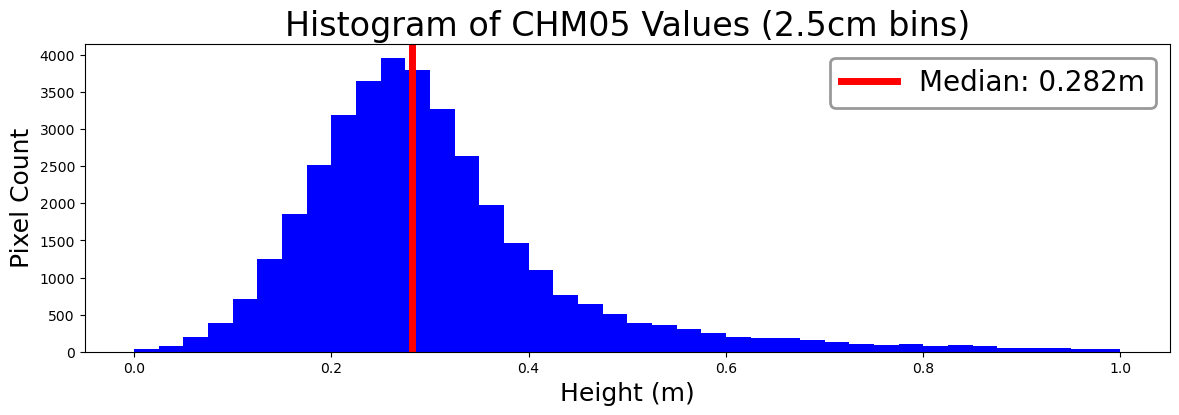

In [16]:
bins = np.linspace(0,1,41)
title = 'Histogram of CHM05 Values (2.5cm bins)'

plt.subplots(figsize=(14,4))
plt.axvline(arr05med, color = 'r', linewidth = 5, label = 'Median: ' + str(round(arr05med, 3)) + 'm')
plt.hist(arr05hstack, bins = bins, color = 'b')
plt.title(title, size = 24)
plt.xlabel('Height (m)', size = 18)
plt.ylabel('Pixel Count', size = 18)
leg = plt.legend(loc = 'upper right', fontsize = '20')
leg.get_frame().set_edgecolor('gray')
leg.get_frame().set_linewidth(2)
plt.savefig(figpath + title + '.png', bbox_inches='tight')
plt.show()

### 6.0 - Vegetation Height Profiles

 - A shapefile was generated from the boundary of the las file, here we convert the polygon to points 
 - FID=0 and FID=2 are selected (these are at the southwest and northeast)
 - A line is created from these two points
 - Points are generated along the line at intervals set by the Sampling Distance 
 - Values from the CHM04 and CHM05 rasters are appended to the points 
 - These values are read into a dataframe and plotted 
 - The top variable in the cell sets the sampling distance for the profile 


#### Generating LAS height profiles

1) Start with LAS 
2) Convert LAS to polygon shapefile
3) Convert polygon to points (at vertices)
4) Select points at opposite ends (SW and NE corners)
5) Generate a line between the two points 
6) Generate points along the transect line (at specified intervals)
7) Add raster (CHM) values to points 
8) Plot the values 

![](./images/LAS.gif) 

#### Plotting LAS height profiles

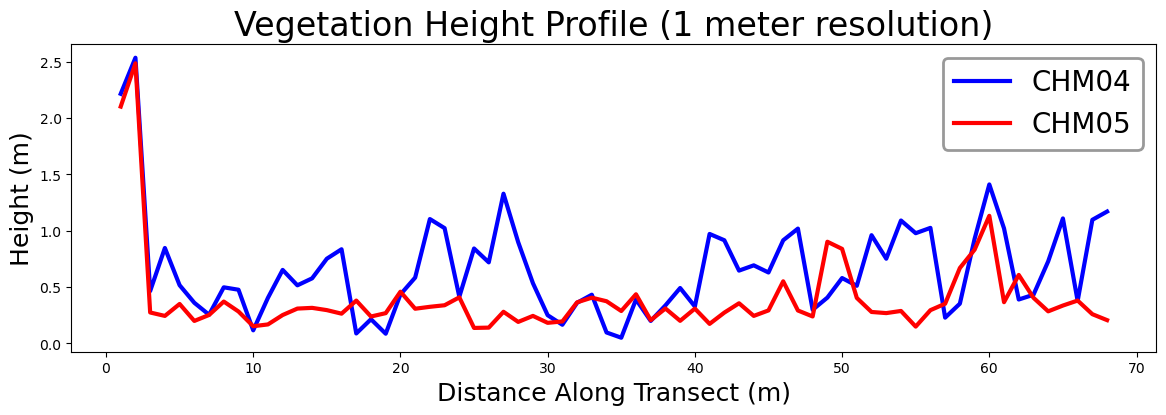

In [17]:
sample_dist = '1 meter'
title = 'Vegetation Height Profile (' + sample_dist + ' resolution)'

infopts = arcpy.management.FeatureVerticesToPoints(info04, 'info_pts.shp', 'ALL')
infosel = arcpy.management.SelectLayerByAttribute(infopts, 'NEW_SELECTION', where_clause="FID = 0 Or FID = 2")
infoline = arcpy.management.CopyFeatures(infosel, 'infosel.shp')
epro_line = arcpy.management.PointsToLine(infoline, 'epro_line.shp')

# arcpy.management.Delete('info_pts.shp')
# arcpy.management.Delete('infosel.shp')

arcpy.management.GeneratePointsAlongLines(epro_line, 'epro_pts.shp', 'DISTANCE', sample_dist, Include_End_Points = 'NO_END_POINTS', Add_Chainage_Fields = 'ADD_CHAINAGE')
ExtractMultiValuesToPoints('epro_pts.shp', [[CHM04, 'CHM04'], [CHM05, 'CHM05']])

arcpy.conversion.ExportTable('epro_pts.dbf', 'epro_pts.csv')
epro_csv = pd.read_csv('epro_pts.csv')
epro_csv['DIST'] = epro_csv['ORIG_LEN']
epro_sub = epro_csv[['DIST', 'CHM04', 'CHM05']]
epro = epro_sub.set_index('DIST')

plt.subplots(figsize=(14,4))
plt.plot(epro.index, epro['CHM04'], color = 'b', linewidth = 3, label = 'CHM04')
plt.plot(epro.index, epro['CHM05'], color = 'r', linewidth = 3, label = 'CHM05')

plt.title(title, size = 24)
plt.xlabel('Distance Along Transect (m)', size = 18)
plt.ylabel('Height (m)', size = 18)
leg = plt.legend(loc = 'upper right', fontsize = '20')
leg.get_frame().set_edgecolor('gray')
leg.get_frame().set_linewidth(2)
plt.savefig(figpath + title + '.png', bbox_inches='tight')
plt.show()

A 50 cm sampling distance is tried. The plot title is also updated automagically. 

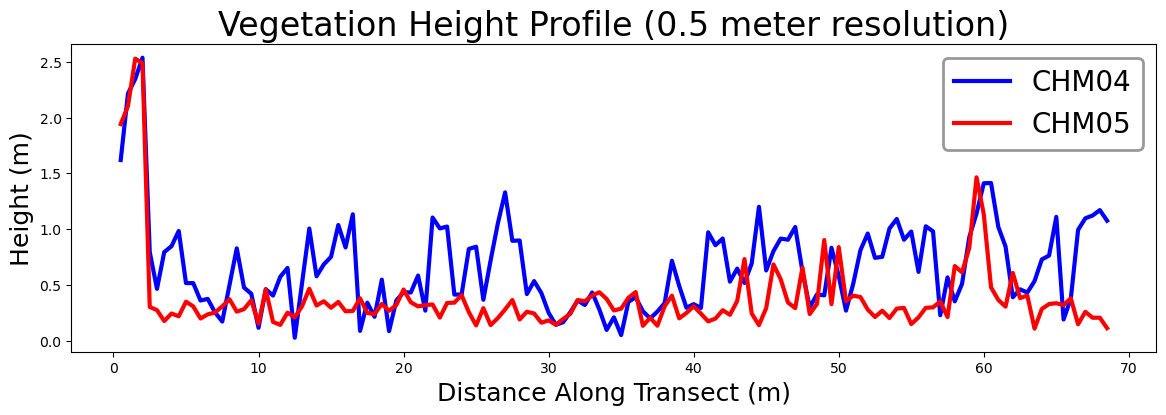

In [18]:
sample_dist = '0.5 meter'
title = 'Vegetation Height Profile (' + sample_dist + ' resolution)'

infopts = arcpy.management.FeatureVerticesToPoints(info04, 'info_pts.shp', 'ALL')
infosel = arcpy.management.SelectLayerByAttribute(infopts, 'NEW_SELECTION', where_clause="FID = 0 Or FID = 2")
infoline = arcpy.management.CopyFeatures(infosel, 'infosel.shp')
epro_line = arcpy.management.PointsToLine(infoline, 'epro_line.shp')

arcpy.management.Delete('info_pts.shp')
arcpy.management.Delete('infosel.shp')

arcpy.management.GeneratePointsAlongLines(epro_line, 'epro_pts.shp', 'DISTANCE', sample_dist, Include_End_Points = 'NO_END_POINTS', Add_Chainage_Fields = 'ADD_CHAINAGE')
ExtractMultiValuesToPoints('epro_pts.shp', [[CHM04, 'CHM04'], [CHM05, 'CHM05']])

arcpy.conversion.ExportTable('epro_pts.dbf', 'epro_pts.csv')
epro_csv = pd.read_csv('epro_pts.csv')
epro_csv['DIST'] = epro_csv['ORIG_LEN']
epro_sub = epro_csv[['DIST', 'CHM04', 'CHM05']]
epro = epro_sub.set_index('DIST')

plt.subplots(figsize=(14,4))
plt.plot(epro.index, epro['CHM04'], color = 'b', linewidth = 3, label = 'CHM04')
plt.plot(epro.index, epro['CHM05'], color = 'r', linewidth = 3, label = 'CHM05')

plt.title('Vegetation Height Profile (' + sample_dist + ' resolution)', size = 24)
plt.xlabel('Distance Along Transect (m)', size = 18)
plt.ylabel('Height (m)', size = 18)
leg = plt.legend(loc = 'upper right', fontsize = '20')
leg.get_frame().set_edgecolor('gray')
leg.get_frame().set_linewidth(2)
plt.savefig(figpath + title + '.png', bbox_inches='tight')
plt.show()

Sampling Distance of 2m is tried. 

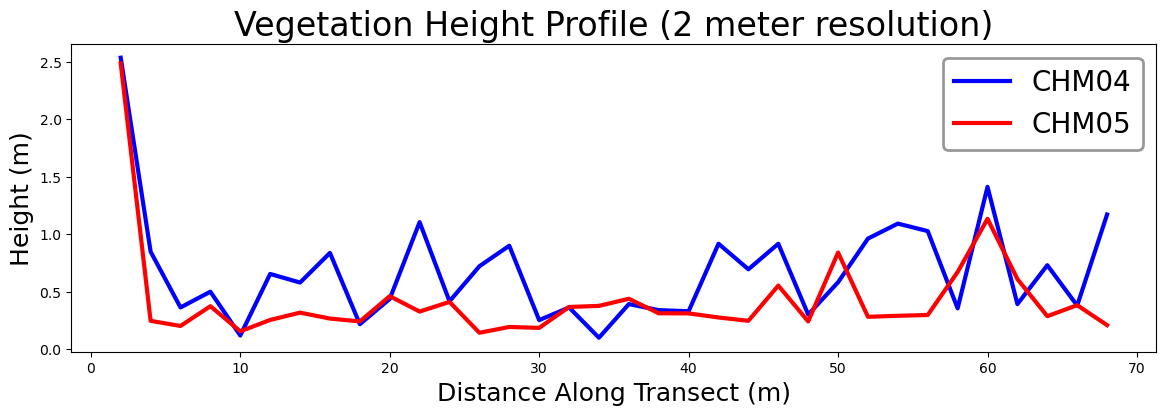

In [19]:
sample_dist = '2 meter'
title = 'Vegetation Height Profile (' + sample_dist + ' resolution)'

infopts = arcpy.management.FeatureVerticesToPoints(info04, 'info_pts.shp', 'ALL')
infosel = arcpy.management.SelectLayerByAttribute(infopts, 'NEW_SELECTION', where_clause="FID = 0 Or FID = 2")
infoline = arcpy.management.CopyFeatures(infosel, 'infosel.shp')
epro_line = arcpy.management.PointsToLine(infoline, 'epro_line.shp')

arcpy.management.Delete('info_pts.shp')
arcpy.management.Delete('infosel.shp')

arcpy.management.GeneratePointsAlongLines(epro_line, 'epro_pts.shp', 'DISTANCE', sample_dist, Include_End_Points = 'NO_END_POINTS', Add_Chainage_Fields = 'ADD_CHAINAGE')
ExtractMultiValuesToPoints('epro_pts.shp', [[CHM04, 'CHM04'], [CHM05, 'CHM05']])

arcpy.conversion.ExportTable('epro_pts.dbf', 'epro_pts.csv')
epro_csv = pd.read_csv('epro_pts.csv')
epro_csv['DIST'] = epro_csv['ORIG_LEN']
epro_sub = epro_csv[['DIST', 'CHM04', 'CHM05']]
epro = epro_sub.set_index('DIST')

plt.subplots(figsize=(14,4))
plt.plot(epro.index, epro['CHM04'], color = 'b', linewidth = 3, label = 'CHM04')
plt.plot(epro.index, epro['CHM05'], color = 'r', linewidth = 3, label = 'CHM05')

plt.title('Vegetation Height Profile (' + sample_dist + ' resolution)', size = 24)
plt.xlabel('Distance Along Transect (m)', size = 18)
plt.ylabel('Height (m)', size = 18)
leg = plt.legend(loc = 'upper right', fontsize = '20')
leg.get_frame().set_edgecolor('gray')
leg.get_frame().set_linewidth(2)
plt.savefig(figpath + title + '.png', bbox_inches='tight')
plt.show()

### 7.0 - Calculate Vegetation Statistics 

##### Generate AOI from LAS
 

A custom function is used to create a shapefile boundary of the las file for further analysis.

In [20]:
def las2aoi(las_file):
    """Creates an area of interest shapefile 
    from an LAS file. This tool assumes 
    WGS 1984 UTM Zone 14N and NAVD88 height (m)
    as spatial reference. 

    Parameters
    -----
    las: object
        las file or variable 

    Returns
    -----
    shapefile (AOI.shp) and variable (aoi)

    """
    sr = arcpy.SpatialReference(32614, 5703)
    aoi = arcpy.ddd.PointFileInformation(las_file, 'AOI.shp', 'LAS')
    arcpy.management.DefineProjection(aoi, sr)
    return aoi 

# las2aoi in use
las2aoi(las05)

<Result 'c:\\Users\\justi\\OneDrive - Texas A&M University\\Academics\\GEOG 676 - GIS Prog\\_group_project\\_Team_LASERS_notebook\\output\\AOI.shp'>

##### Calculate Zonal Stats (max, min, mean, etc.)

In [21]:
ZonalStatisticsAsTable('AOI.shp', 'FID', 'CHM04.tif', 'CHM04_zs_table.dbf', 'DATA', 'ALL')
ZonalStatisticsAsTable('AOI.shp', 'FID', 'CHM05.tif', 'CHM05_zs_table.dbf', 'DATA', 'ALL')

<geoprocessing server result object at 0x16444f5d9f0>

#### Convert DBF to CSV

In [22]:
arcpy.conversion.ExportTable('CHM04_zs_table.dbf', 'CHM04_zs_table.csv')
arcpy.conversion.ExportTable('CHM05_zs_table.dbf', 'CHM05_zs_table.csv')

<Result 'c:\\Users\\justi\\OneDrive - Texas A&M University\\Academics\\GEOG 676 - GIS Prog\\_group_project\\_Team_LASERS_notebook\\output\\CHM05_zs_table.csv'>

#### Compile stats into single dataframe

In [23]:
df04 = pd.read_csv('CHM04_zs_table.csv')
df05 = pd.read_csv('CHM05_zs_table.csv')
df0405 = pd.concat([df04, df05])
df0405_sub = df0405[['MIN', 'MAX', 'RANGE', 'MEAN', 'MEDIAN', 'PCT90']]
df0405_sub.index = ['April', 'May']
df0405_sub

,MIN,MAX,RANGE,MEAN,MEDIAN,PCT90
April,0.0,3.583405,3.583405,0.729336,0.700401,1.166397
May,0.0,3.655403,3.655403,0.352887,0.282097,0.511795


#### Calculate volume $m^{3}$

In [24]:
arcpy.ddd.SurfaceVolume(CHM04, "vol04.txt", reference_plane="ABOVE")
arcpy.ddd.SurfaceVolume(CHM05, "vol05.txt", reference_plane="ABOVE")
v04 = pd.read_csv('vol04.txt')
v05 = pd.read_csv('vol05.txt')
vol04 = v04.loc[0, ' Volume']
vol05 = v05.loc[0, ' Volume']
stats = df0405_sub.copy()
stats['VOLUME'] = [vol04, vol05]
stats

,MIN,MAX,RANGE,MEAN,MEDIAN,PCT90,VOLUME
April,0.0,3.583405,3.583405,0.729336,0.700401,1.166397,1715.319155
May,0.0,3.655403,3.655403,0.352887,0.282097,0.511795,829.379243


#### Estimate aboveground dry matter (kg) from volume ($m^{3}$)

In [25]:
# Assuming 1 cubic meter of vegetation equals (x) kg of dry matter  
xkg = 2 # kg/m^3
stats['MASS_kg'] = [vol04 * xkg, vol05 * xkg]
stats

,MIN,MAX,RANGE,MEAN,MEDIAN,PCT90,VOLUME,MASS_kg
April,0.0,3.583405,3.583405,0.729336,0.700401,1.166397,1715.319155,3430.638309
May,0.0,3.655403,3.655403,0.352887,0.282097,0.511795,829.379243,1658.758486


#### Estimate Total Carbon (metric tonnes (t)) from dry matter (kg) 

In [26]:
# Assuming (x) kg of Carbon from 1 kg dry matter  
xC = 0.25 # C(kg)/dry(kg) 
mass04 = stats.loc['April', 'MASS_kg']
mass05 = stats.loc['May', 'MASS_kg']
stats['C_t'] = [mass04 * xC /1000, mass05 * xC / 1000]
stats

,MIN,MAX,RANGE,MEAN,MEDIAN,PCT90,VOLUME,MASS_kg,C_t
April,0.0,3.583405,3.583405,0.729336,0.700401,1.166397,1715.319155,3430.638309,0.85766
May,0.0,3.655403,3.655403,0.352887,0.282097,0.511795,829.379243,1658.758486,0.41469


### 8.0 - Estimate Carbon value (USD)

In [27]:
price_per_credit_low = 40 # $USD/t

c04 = stats.loc['April', 'C_t']
c05 = stats.loc['May', 'C_t']

print('Total Carbon value, Apr: $' + str(round(c04 * price_per_credit_low, 2)) + ' USD')
print('Total Carbon value, May: $' + str(round(c05 * price_per_credit_low, 2)) + ' USD')

Total Carbon value, Apr: $34.31 USD
Total Carbon value, May: $16.59 USD


### 9.0 - Estimate Percent Cover and Biomass 

In [28]:
# list given cover values for each month
cover_values = [98.9,99.8]

# calculate biomass for each month using equation from Chojnacky and Milton 2008
def calculate_biomass(cover):
    return math.exp(-3.96457 + 1.08631 * math.log(cover))

# add a conversion factor to change units from Mg/ha to lbs/acre
## not 100% necessary but it makes the number easier to conceptualize
conver_factor_Mg_lbs = 2204.62
conver_factor_ha_ac = 2.47105
conver_factor = conver_factor_Mg_lbs / conver_factor_ha_ac

# loop through each month and run the function
for month, cover in enumerate(cover_values, start = 1):
    biomass = calculate_biomass(cover) * conver_factor
    print(f"Month {month}: Cover = {cover}%, Biomass = {biomass:.2f} lbs/acre")

Month 1: Cover = 98.9%, Biomass = 2489.22 lbs/acre
Month 2: Cover = 99.8%, Biomass = 2513.84 lbs/acre


### 10.0 - Forage Calculations

In [29]:
#Forage Supply
def calculate_forage(pounds_per_acre, grazing_efficiency):
    forage_available = pounds_per_acre * grazing_efficiency
    return forage_available

#Forage Demand
def calculate_forage_required(animal_weight):
    forage_percentage = 0.03  # 3.0% represented as 0.03
    pounds_forage_required = animal_weight * forage_percentage
    return pounds_forage_required

#Pasture Size
def calculate_forage_requirement(forage_demand_per_day, num_animals, forage_supply_per_acre, grazing_period_days):
    total_forage_demand = (forage_demand_per_day * num_animals) / forage_supply_per_acre
    total_forage_requirement = total_forage_demand * grazing_period_days
    return total_forage_requirement

#Animal Number
def calculate_forage_ratio(forage_supply_per_acre, pasture_size_acres, forage_demand_per_day, grazing_period_days):
    forage_supply_total = forage_supply_per_acre * pasture_size_acres
    forage_demand_total = forage_demand_per_day * grazing_period_days
    ratio = forage_supply_total / forage_demand_total
    return ratio

#Grazing Period
def calculate_forage_ratio_animal(forage_supply_per_acre, pasture_size_acres, forage_demand_per_day, num_animals):
    forage_supply_total = forage_supply_per_acre * pasture_size_acres
    forage_demand_total = forage_demand_per_day * num_animals
    ratio = forage_supply_total / forage_demand_total
    return ratio

# stocking rate
def calculate_stocking_rate(forage_available, pounds_forage_required, grazing_period_days, pasture_size_acres):
    head = forage_available / (grazing_period_days * pounds_forage_required)
    stock_rate = pasture_size_acres / (head * grazing_period_days)
    return stock_rate

pounds_per_acre_air_dry = biomass # dry weight biomass was calculated earlier. sub in different biomass values for each month
grazing_efficiency = 0.50  # let's say we'll rotate the cows once a week
animal_weight = 1000  # Cow is 1000 lbs (low end estimate)
animals = 1  # One cow
grazing_period = 180 # half the year
pasture_size = 0.6

forage_supply = calculate_forage(pounds_per_acre_air_dry, grazing_efficiency)
forage_demand = calculate_forage_required(animal_weight)
pasture_size = calculate_forage_requirement(forage_demand, animals, forage_supply, grazing_period)
forageratio = calculate_forage_ratio(forage_supply, pasture_size, forage_demand, grazing_period)
grazing_period = calculate_forage_ratio_animal(forage_supply, pasture_size, forage_demand, animals)
stock_rate = calculate_stocking_rate(pounds_per_acre_air_dry, forage_demand, grazing_period, pasture_size)

print(f"Forage available: {forage_supply:.0f} pounds per acre")
print(f"Forage required per day: {forage_demand} pounds")
print(f"Total forage requirement for the given period: {pasture_size:.3f} pounds")
print(f"Forage supply to demand ratio: {forageratio}")
print(f"Forage supply to demand ratio based on animal count: {grazing_period}")
print(f"Potential stocking rate for study site: {stock_rate:.3f}")

Forage available: 1257 pounds per acre
Forage required per day: 30.0 pounds
Total forage requirement for the given period: 4.296 pounds
Forage supply to demand ratio: 1.0
Forage supply to demand ratio based on animal count: 180.0
Potential stocking rate for study site: 0.051
